In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.data import make_mini_batcher
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian



# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-05-30 08:04:00.495409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Argumentsget_data_args

In [3]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

args.smoke_test = True
args.wandb_mode = "online"
args.wandb_resume = True
args.id = "2uuq7tks"

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin
wandb: WARNING Tried to auto resume run with id 1awner87 but id 2uuq7tks is set.
2022-05-30 08:04:06.155003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Load Data

In [7]:
%%time

# load data
data = load_data(args)

# preprocess data
data = preprocess_data(data, args)

# feature transformation
data, scaler = feature_transform(data, args)

# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

100%|██████████| 6/6 [00:00<00:00, 12.02it/s]


CPU times: user 2.76 s, sys: 3.28 s, total: 6.04 s
Wall time: 6.43 s


In [8]:
data[["longitude", "latitude", "time_transform"]].head()

,longitude,latitude,time_transform
0,0.633663,-0.998266,-1.0
1,0.632683,-0.994338,-1.0
2,0.631703,-0.990410,-1.0
3,0.630723,-0.986482,-1.0
4,0.629742,-0.982554,-1.0


### Model

In [9]:
%%time


# model
model = get_model(args)

# optimizer
optimizer = get_optimizer(args)

# loss
make_step, val_step = get_loss_fn(args)

# init model
opt_state = optimizer.init(model)

CPU times: user 1.25 s, sys: 12 ms, total: 1.26 s
Wall time: 1.25 s


In [10]:
n_steps_per_epoch = args.n_train / args.batch_size
steps = int(n_steps_per_epoch * args.n_epochs) if not args.smoke_test else 500


wandb.config.update(
    {
        "steps": steps,
        "n_steps_per_epoch": n_steps_per_epoch,
    }
)

### Training

In [ ]:
train_ds = make_mini_batcher(xtrain, ytrain, args.batch_size, 1, shuffle=True)
valid_ds = make_mini_batcher(xvalid, yvalid, args.batch_size, 1, shuffle=False)


losses = {} 
losses["train"] = []
losses["valid"] = []


with tqdm.trange(steps) as pbar:
    for step in pbar:
        
        ix, iy = train_ds()
        loss, grads = make_step(model, ix, iy)
        
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        losses["train"].append(loss)
        wandb.log({"train_loss": loss}, step=step)
        ix, iy = valid_ds()
        # validation step
        vloss = val_step(model, ix, iy)
        losses["valid"].append(vloss)
        
        
        wandb.log({"val_loss": vloss}, step=step)
        
        if step % 10 == 0:
            pbar.set_description(f"Step: {step:_} | Train Loss: {loss:.3e} | Valid Loss: {vloss:.3e}")
            


2022-05-29 19:39:50.968914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-29 19:39:50.968942: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Step: 190 | Train Loss: 2.411e-02 | Valid Loss: 2.565e-02:  39%|███▊      | 193/500 [01:20<02:07,  2.41it/s]

### Save models

In [ ]:
# objects
path_model = Path(wandb.run.dir).joinpath("model.pickle")
path_scaler = Path(wandb.run.dir).joinpath("scaler.pickle")

# models to save
save_object(model, path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_model), policy="now")
wandb.save(str(path_scaler), policy="now")

### Load Models (Optional)

In [41]:
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = ["scaler.pickle", "model.pickle"]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [42]:
model = load_object("./model.pickle")
scaler = load_object("./scaler.pickle")

### PostProcessing

In [52]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude
count,967980.000000,967980.000000
mean,300.000000,38.100000
std,2.943922,3.001668
min,295.000000,33.000000
25%,297.400000,35.550000
50%,300.000000,38.100000
75%,302.600000,40.650000
max,305.000000,43.200000


In [53]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe(), df_grid.describe()

(          longitude       latitude  time_transform
 count  9.679800e+05  967980.000000   967980.000000
 mean  -2.666668e-07       0.006669       -0.000004
 std    1.962616e-01       0.200112        0.494783
 min   -3.333338e-01      -0.333332       -0.854648
 25%   -1.733337e-01      -0.163331       -0.427326
 50%   -2.666668e-07       0.006669       -0.000004
 75%    1.733332e-01       0.176670        0.427317
 max    3.333333e-01       0.346671        0.854639,
            longitude       latitude
 count  967980.000000  967980.000000
 mean      300.000000      38.100000
 std         2.943922       3.001668
 min       295.000000      33.000000
 25%       297.400000      35.550000
 50%       300.000000      38.100000
 75%       302.600000      40.650000
 max       305.000000      43.200000)

In [54]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

### Predictions


In [55]:
@jax.jit
def pred_step(model, data):
    return jax.vmap(model)(data)

In [56]:
from ml4ssh._src.model_utils import batch_predict
from functools import partial
import time

In [57]:
df_pred = jnp.asarray(df_pred[df_pred.columns.difference(["time"])].values)

fn = partial(pred_step, model)

t0 = time.time()
df_grid["pred"] = batch_predict(df_pred, fn, args.eval_batch_size)
t1 = time.time() - t0

97it [00:10,  9.47it/s]


In [58]:
wandb.config.update(
    {
        "time_predict_batches": t1,
    }
)

In [61]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xarray/core/miss

In [62]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    pred       (latitude, longitude, time) float32 -0.01623 -0.02006 ... 0.0961
    ssh        (latitude, longitude, time) float64 0.5835 0.5796 ... -0.08024

In [63]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

CPU times: user 412 ms, sys: 36 ms, total: 448 ms
Wall time: 431 ms


In [64]:
psd_metrics = get_psd_metrics(ds_oi, args)

### Figures

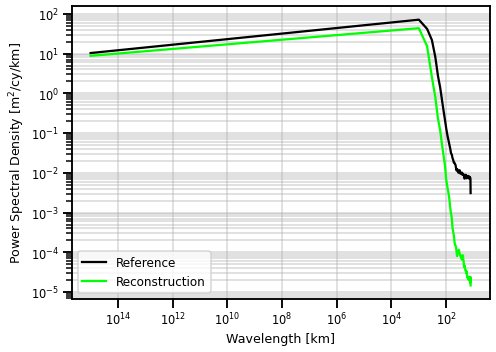

In [65]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

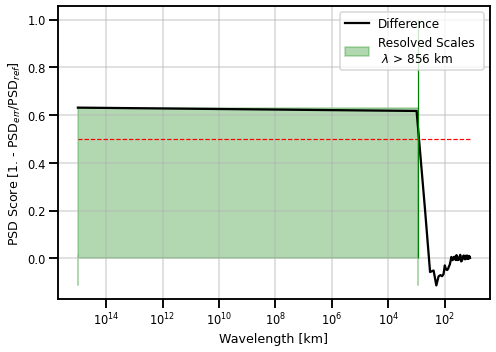

In [66]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [31]:
if args.smoke_test:
    create_movie(ds_oi.ssh.isel(time=slice(50,60)), "pred", "time", cmap="viridis")
else:
    create_movie(ds_oi.ssh, "pred", "time", cmap="viridis")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Movie created at movie_pred.mp4
GIF created at movie_pred.gif


In [32]:
wandb.log(
    {
        "predictions_gif": wandb.Image("movie_pred.gif"),
    }
)

### Gradients

In [33]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [34]:
if args.smoke_test:
    create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), "pred_grad", "time", cmap="Spectral_r")
else:
    create_movie(ds_oi.ssh_grad, "pred_grad", "time", cmap="Spectral_r")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Movie created at movie_pred_grad.mp4
GIF created at movie_pred_grad.gif


In [35]:
wandb.log(
    {
        "predictions_grad_gif": wandb.Image("movie_pred_grad.gif"),
    }
)

### Laplacian

In [36]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [37]:
if args.smoke_test:
    create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), "pred_lap", "time", cmap="RdBu_r")
else:
    create_movie(ds_oi.ssh_lap, "pred_lap", "time", cmap="RdBu_r")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Movie created at movie_pred_lap.mp4
GIF created at movie_pred_lap.gif


In [38]:
wandb.log(
    {
        "predictions_laplacian_gif": wandb.Image("movie_pred_lap.gif"),
    }
)